**Image classification**

Import libraries

In [1]:
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import numpy as np

from keras.datasets import cifar10
from keras.models import Model
from keras.models import Sequential
from keras.layers import MaxPooling2D, Conv2D, Dropout, Dense, Flatten, Concatenate, BatchNormalization, Lambda, Activation
import keras
from keras import backend as K
from keras.optimizers import SGD,RMSprop, Adam, Adadelta
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Input

from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec

Using TensorFlow backend.
C:\Users\Weronika\Anaconda3\envs\n4\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Weronika\Anaconda3\envs\n4\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Weronika\Anaconda3\envs\n4\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Weronika\Anaconda3\envs\n4\lib\site-pa

Load a sample datasets

In [2]:
(trainX, trainy), (testX, testy) = cifar10.load_data()


Data normalization 

In [3]:
trainX = np.asarray(trainX)/255
testX = np.asarray(testX)/255


Split the set of training, validation and test data

In [4]:
trainX, valX, trainy, valy = train_test_split(trainX, trainy, random_state=0, test_size=0.1, stratify=trainy)


Categorize the dataset

In [5]:
trainy = keras.utils.to_categorical(trainy, 10)
valy = keras.utils.to_categorical(valy, 10)
testy = keras.utils.to_categorical(testy, 10)

Function used for visualizing original and reconstructed images

In [6]:
dict = {0:'plane', 1:'car', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

def showOrigDec(orig, dec, num=2):
    n = num
    plt.figure(figsize=(10, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(orig[300*i].reshape(til,til, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[300*i].reshape(til,til, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Function used for visualizing the predicted and true labels of test data

In [7]:
def test_images_show(model_c, dset):  
    plt.figure(figsize =(40,8))
    for i in range(5):
        ax = plt.subplot(1, 5, i+1)
        test_image = np.expand_dims(dset[101*i+5], axis=0)
        test_result = model_c.predict(test_image)
        plt.imshow(testX[101*i+5])
        index = np.argsort(test_result[0,:])
        plt.title("Pred:{}, True:{}".format(dict[index[1]], dict[testy[101*i+5][1]]))
    plt.show()

Function used for creating a classification report and confusion matrix

In [8]:
def report_class(predictions):
    cm=confusion_matrix(testy.argmax(axis=1), predictions.argmax(axis=1))
    print("Classification Report:\n")
    creport=classification_report(testy.argmax(axis=1),
                                predictions.argmax(axis=1), 
                                target_names=list(dict.values()))
    print(creport)
    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, xticklabels = list(dict.values()), yticklabels = list(dict.values()), fmt="d",annot_kws={"size": 20})
    

Advanced focal loss function 

In [9]:
def categorical_focal_loss(gamma=2., alpha=.25):
    """
    Softmax version of focal loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Sum the losses in mini_batch
        return K.sum(loss, axis=1)

    return categorical_focal_loss_fixed

Run model depends on used data augmentation

In [10]:
def runModel(aug):
    er = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
    lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_delta=0.0001)
    callbacks = [er, lr]
    
    if not aug:
        history = model.fit(trainX, trainy, batch_size=batch_size,
                                 epochs=epochs,
                                 verbose=1, callbacks=callbacks,
                                 validation_data=(valX,valy))

    else:
        train_datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
        train_set_aug = train_datagen.flow(trainX, trainy, batch_size=batch_size)

        validation_datagen = ImageDataGenerator()
        validation_set_aug = validation_datagen.flow(valX, valy, batch_size=batch_size)
        
        history = model.fit_generator(train_set_aug,
                                           epochs=epochs,
                                           steps_per_epoch=np.ceil(trainX.shape[0]/batch_size),
                                           verbose=1, callbacks=callbacks,
                                           validation_data=(validation_set_aug),
                                           validation_steps=np.ceil(valX.shape[0]/batch_size))

        
        return history

Model parammeters

In [11]:
epochs = 10
batch_size = 100
size = trainX.shape[1]

Custom model architecture

In [12]:
def model_conv():
    
    inputs = Input((size, size, 3))

    c1 = Conv2D(4, (3, 3),  padding = 'same')(inputs)
    c1 = BatchNormalization()(c1) 
    c1 = Activation('relu')(c1)
    c1 = Conv2D(4, (3, 3),  padding = 'same')(c1)
    c1 = BatchNormalization()(c1) 
    c1 = Activation('relu')(c1)

    c1 = MaxPooling2D(2, 2)(c1)

    c2 = Conv2D(16, (3, 3),  padding = 'same')(c1)
    c2 = BatchNormalization()(c2) 
    c2 = Activation('relu')(c2)
    c2 = Conv2D(16, (3, 3),  padding = 'same')(c2)
    c2 = BatchNormalization()(c2) 
    c2 = Activation('relu')(c2)

    c2 = MaxPooling2D(2, 2)(c2)


    c3 = Conv2D(32, (3, 3),  padding = 'same')(c2)
    c3 = BatchNormalization()(c3) 
    c3 = Activation('relu')(c3)
    c3 = Conv2D(32, (3, 3),  padding = 'same')(c3)
    c3 = BatchNormalization()(c3) 
    c3 = Activation('relu')(c3)

    c3 = MaxPooling2D(2, 2)(c3)

    c4 = Conv2D(64, (3, 3),  padding = 'same')(c3)
    c4 = BatchNormalization()(c4) 
    c4 = Activation('relu')(c4)
    c4 = Conv2D(64, (3, 3),  padding = 'same')(c4)
    c4 = BatchNormalization()(c4) 
    c4 = Activation('relu')(c4)

    c4 = MaxPooling2D(2, 2)(c4)

    c5 = Conv2D(128, (3, 3),  padding = 'same')(c4)
    c5 = BatchNormalization()(c5) 
    c5 = Activation('relu')(c5)
    c5 = Conv2D(128, (3, 3),  padding = 'same')(c5)
    c5 = BatchNormalization()(c5) 
    c5 = Activation('relu')(c5)

    c5 = MaxPooling2D(2, 2)(c5)


    f1 = Flatten()(c5)
    d1 = Dense(64, activation = 'relu')(f1)
    d3 = Dropout(0.2)(d1)

    output = Dense(10, activation = 'softmax')(d3)


    model = Model(inputs = [inputs], outputs = [output])

    model.summary()
    return model


Initialise model

In [13]:
model=model_conv()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 4)         112       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 4)         16        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 4)         148       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 4)         16        
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 4)         0  

Compile model

In [14]:
opt_rms = Adadelta()

model.compile(loss=[categorical_focal_loss(alpha=.05, gamma=2)],
                   optimizer=opt_rms,
                   metrics=['accuracy'])

In [15]:
history=runModel(1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/10
450/450 [==============================] - 163s 362ms/step - loss: 0.0623 - accuracy: 0.3590 - val_loss: 0.0519 - val_accuracy: 0.4036
Epoch 2/10
450/450 [==============================] - 155s 345ms/step - loss: 0.0483 - accuracy: 0.4729 - val_loss: 0.0389 - val_accuracy: 0.4932
Epoch 3/10
450/450 [==============================] - 157s 350ms/step - loss: 0.0433 - accuracy: 0.5150 - val_loss: 0.0412 - val_accuracy: 0.5064
Epoch 4/10
450/450 [==============================] - 155s 344ms/step - loss: 0.0398 - accuracy: 0.5500 - val_loss: 0.0492 - val_accuracy: 0.4824
Epoch 5/10
450/450 [==============================] - 159s 353ms/step - loss: 0.0373 - accuracy: 0.5710 - val_loss: 0.0388 - val_accuracy: 0.5728
Epoch 6/10
450/450 [==============================] - 157s 349ms/step - loss: 0.0350 - accuracy: 0.5925 - val_loss: 0.0402 - val_accuracy: 0.5798
Epoch 7/10
450/450 [=========

Accuracy and loss charts

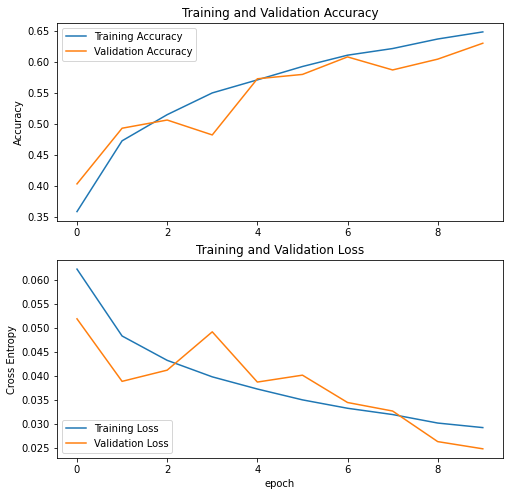

In [16]:

acc =history.history['accuracy']
val_acc =history.history['val_accuracy']
loss =history.history['loss']
val_loss=history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.ylabel('Cross Entropy')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Check a sample of the classification

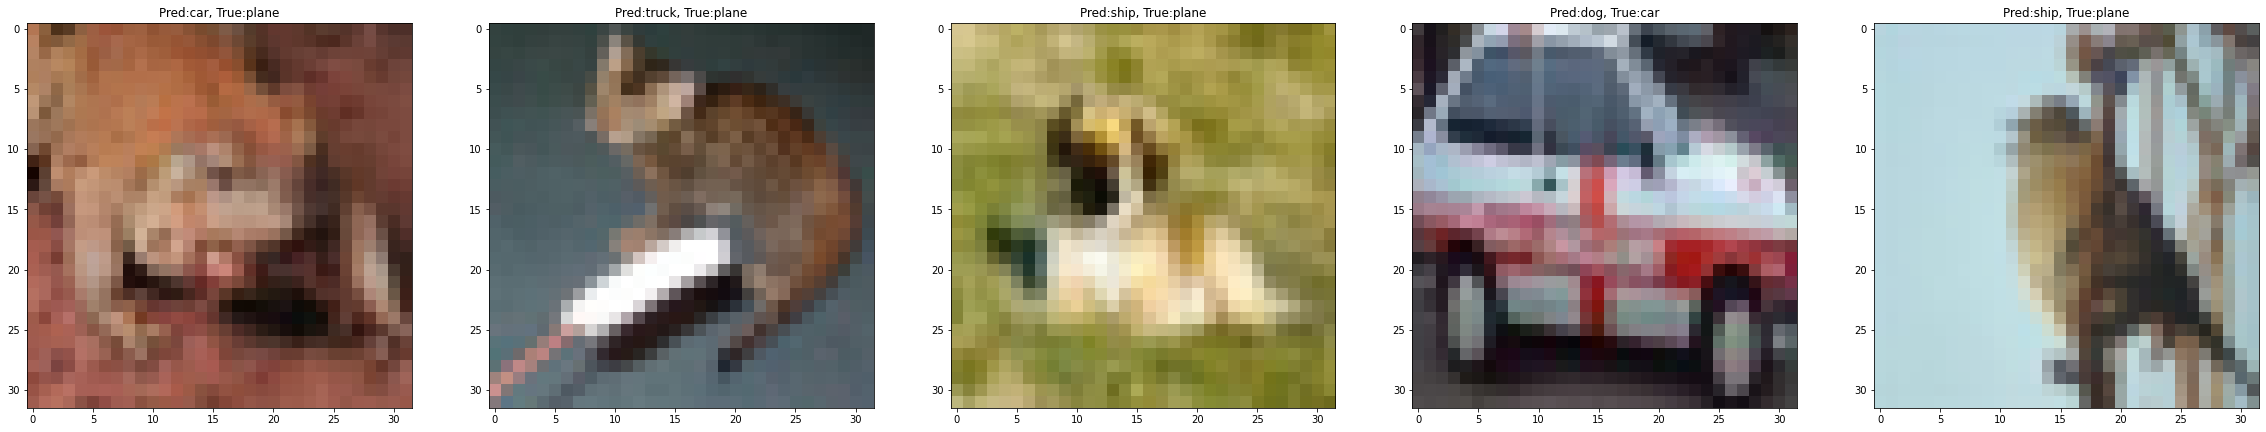

In [17]:
test_images_show(model, testX)

Predict test data and Classification summary

Classification Report:

              precision    recall  f1-score   support

       plane       0.72      0.64      0.68      1000
         car       0.74      0.80      0.77      1000
        bird       0.47      0.62      0.54      1000
         cat       0.58      0.24      0.34      1000
        deer       0.67      0.39      0.49      1000
         dog       0.53      0.61      0.56      1000
        frog       0.58      0.84      0.69      1000
       horse       0.69      0.71      0.70      1000
        ship       0.87      0.69      0.77      1000
       truck       0.62      0.81      0.70      1000

    accuracy                           0.63     10000
   macro avg       0.65      0.63      0.62     10000
weighted avg       0.65      0.63      0.62     10000



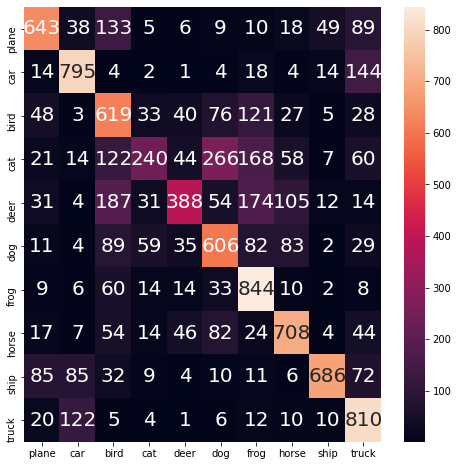

In [18]:
predictions = model.predict(testX)
report_class(predictions)

Save and load model

In [19]:

# Save the weights
model.save_weights('model_weights.h5')

# Save the model architecture
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())

In [20]:

#load model
from keras.models import model_from_json

# Model reconstruction from JSON file
with open('model_architecture.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('model_weights.h5')